In [1]:
import os,sys
from glob import glob
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib
import fiona
import rasterio as rio
from rasterio.features import rasterize

# helpers
from xarr_helpers import *


In [2]:
# load the table mountain shapefile
point_file = r"../arc/headwall_neon_poi.shp"
gdf = gpd.read_file(point_file)
print('point CRS: {}'.format(gdf.crs))

gdf_4326 = gdf.to_crs(epsg=4326)
gdf_4326.head()

point CRS: {'init': 'epsg:32613'}


,Id,comments,geometry
0,0,NEON light tarp center,POINT (-105.2449209483192 40.13056064633826)
1,0,NEON dark tarp center,POINT (-105.2450429801881 40.13055609737145)
2,0,some other target?,POINT (-105.2449348460157 40.13027956799884)
3,0,road sample east of tarps,POINT (-105.2445969512152 40.13050721903751)
4,0,4-way intersection,POINT (-105.2445888333624 40.1306683804434)


In [ ]:
# NEON data files
data_dirs = !ls -d ../neon_data/*
radiance_files_april09 = glob(data_dirs[0] + '/L1/Spectrometer/RadianceH5/2019040915/*.h5')
radiance_files_april10 = glob(data_dirs[1] + '/L1/Spectrometer/RadianceH5/2019040920/*.h5')

reflectance_files_april09 = glob(data_dirs[0] + '/L1/Spectrometer/ReflectanceH5/2019040915/*.h5')
reflectance_files_april10 = glob(data_dirs[1] + '/L1/Spectrometer/ReflectanceH5/2019040920/*.h5')


# Headwall data files. Currently, only the Surface Reflectance products have been downloaded.
data_dirs_SWIR = !ls -d ../headwall_data/SWIR/*
data_dirs_VNIR = !ls -d ../headwall_data/VNIR/*

# first two directories will be from table mountain. second two are from tennis courts @ CU South
radiance_files_VNIR_april09 = glob(data_dirs_VNIR[0] + '/*.hdr')
radiance_files_VNIR_april09 = [f[:-4] for f in radiance_files_VNIR_april09] # remove the .hdr

radiance_files_SWIR_april09 = glob(data_dirs_SWIR[0] + '/*.hdr')
radiance_files_SWIR_april09 = [f[:-4] for f in radiance_files_SWIR_april09] # remove the .hdr


In [ ]:
reflectance_files_april09, radiance_files_VNIR_april09, radiance_files_SWIR_april09

In [ ]:
## try to open one of the data files with xarray
neon_ind=4
if neon_ind % 2 == 0:
    fl_dir = 'NS'
else:
    fl_dir = 'EW'
    
hw_ind=1
data_file_VNIR = radiance_files_VNIR_april09[hw_ind]
data_file_SWIR = radiance_files_SWIR_april09[hw_ind]
data_file_NEON = reflectance_files_april09[neon_ind] # NEON_D10_R10C_DP1_20190409_172333_reflectance

neon_id = os.path.basename(data_file_NEON).split('_')[2] # e.g., 'R10C'
print('NEON ID: ', neon_id)
print(data_file_VNIR)

In [ ]:
## read the data into xarray datasets, chunk with Dask
# first Headwall
xarr_VNIR = xr.open_rasterio(data_file_VNIR, chunks=(256, 256, 256))
xarr_SWIR = xr.open_rasterio(data_file_SWIR, chunks=(256, 256, 256))
x_vnir, y_vnir = xarr_VNIR.coords['x'].values, xarr_VNIR.coords['y'].values
x_swir, y_swir = xarr_SWIR.coords['x'].values, xarr_SWIR.coords['y'].values

In [ ]:
# then NEON (dask chunking done in-function)
x_neon_atcor, y_neon_atcor, xarr_NEON_atcor = NEON_create_refl_xarr_from_h5_file(data_file_NEON, nid=neon_id)

# read the elm corrected data
# data_file_NEON = r"D:\projects\headwall_neon\atcor_aois\elm\test_20190409_163351_radiance_elm.hdr"
# xarr_NEON = xr.open_rasterio(data_file_NEON, chunks=(256, 256, 256), driver='ENVI')

data_file_NEON = r"D:\projects\headwall_neon\atcor_aois\elm\test_20190409_163351_radiance_elm_BSQ"
xarr_NEON = xr.open_rasterio(data_file_NEON, chunks=(256, 256, 256))
x_neon, y_neon = xarr_NEON.coords['x'].values, xarr_NEON.coords['y'].values

In [ ]:
x_neon, y_neon

# Spatial extraction

In [ ]:
buffer_dist = 3 # meters

## use the shapefile
pt_index = 0
pt = gdf_4326['geometry'].values[pt_index]
pt_label = gdf_4326['comments'].values[pt_index]
pt_df = gpd.GeoDataFrame({'geometry' : [pt]}, crs=fiona.crs.from_epsg(4326))

# buffer them in the correct coordinate systems
pt_df_hw = pt_df.to_crs(epsg=3857).buffer(buffer_dist, resolution=1).to_crs(epsg=4326)
pt_df_neon = pt_df.to_crs(epsg=32613).buffer(buffer_dist)

In [ ]:
xarr_NEON.coords

In [ ]:
## do the extraction
neon_sub_cube_atcor, neon_arrs_atcor = extract_from_NEON((xarr_NEON_atcor, x_neon_atcor, y_neon_atcor), pt_df_neon)
neon_sub_cube, neon_arrs = extract_from_NEON_ENVI((xarr_NEON, x_neon, y_neon), pt_df_neon)
hw_vnir_cube, hw_swir_cube, hw_arrs = extract_from_headwall((xarr_VNIR, x_vnir, y_vnir), 
                                                            (xarr_SWIR, x_swir, y_swir),
                                                            pt_df_hw)

neon_wav_atcor, full_neon_atcor = neon_arrs_atcor
neon_wav, full_neon = neon_arrs
full_wav, full_ex = hw_arrs

# plot mean of both systems

In [ ]:
hw_mean = np.nanmean(full_ex, axis=1)
hw_max = np.nanmax(full_ex, axis=1)
hw_min = np.nanmin(full_ex, axis=1)

neon_mean = np.nanmean(full_neon, axis=1)
neon_max = np.nanmax(full_neon, axis=1)
neon_min = np.nanmin(full_neon, axis=1)

neon_mean_atcor = np.nanmean(full_neon_atcor, axis=1)
neon_max_atcor = np.nanmax(full_neon_atcor, axis=1)
neon_min_atcor = np.nanmin(full_neon_atcor, axis=1)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(full_wav, hw_mean)
plt.fill_between(full_wav, hw_min, hw_max, alpha=0.1)
plt.plot(neon_wav, neon_mean)
plt.fill_between(neon_wav, neon_min, neon_max, alpha=0.1)
plt.plot(neon_wav_atcor, neon_mean_atcor)
plt.fill_between(neon_wav_atcor, neon_min_atcor, neon_max_atcor, alpha=0.1)
plt.show()

In [ ]:
## replot masking bad bands:
# 1260 to 1560 nm (Bands 98-128)
# 1760 to 1960 nm (Bands 148-170)
bad_neon = np.where(((neon_wav > 1260) & (neon_wav < 1560)) | ((neon_wav > 1760) & (neon_wav < 1960)))
bad_neon_atcor = np.where(((neon_wav_atcor > 1260) & (neon_wav_atcor < 1560)) | ((neon_wav_atcor > 1760) & (neon_wav_atcor < 1960)))
bad_hw = np.where(((full_wav > 1260) & (full_wav < 1560)) | ((full_wav > 1760) & (full_wav < 1960)))

In [ ]:
hw_mean_ma = hw_mean.copy()
hw_mean_ma[bad_hw] = np.nan
hw_max_ma = hw_max.copy()
hw_max_ma[bad_hw] = np.nan
hw_min_ma = hw_min.copy()
hw_min_ma[bad_hw] = np.nan

neon_mean_ma = neon_mean.copy()
neon_mean_ma[bad_neon] = np.nan
neon_max_ma = neon_max.copy()
neon_max_ma[bad_neon] = np.nan
neon_min_ma = neon_min.copy()
neon_min_ma[bad_neon] = np.nan

neon_mean_ma_atcor = neon_mean_atcor.copy()
neon_mean_ma_atcor[bad_neon_atcor] = np.nan
neon_max_ma_atcor = neon_max_atcor.copy()
neon_max_ma_atcor[bad_neon_atcor] = np.nan
neon_min_ma_atcor = neon_min_atcor.copy()
neon_min_ma_atcor[bad_neon_atcor] = np.nan

In [ ]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

plt.figure(figsize=(20,10))
plt.plot(full_wav, hw_mean_ma, label='Headwall Average')
plt.fill_between(full_wav, hw_min_ma, hw_max_ma, alpha=0.25)
plt.plot(neon_wav, neon_mean_ma, label='NEON Average')
plt.fill_between(neon_wav, neon_min_ma, neon_max_ma, alpha=0.25)
plt.plot(neon_wav_atcor, neon_mean_ma_atcor, label='NEON (ATCOR) Average')
plt.fill_between(neon_wav_atcor, neon_min_ma_atcor, neon_max_ma_atcor, alpha=0.25)

plt.title('Comparison of Headwall NanoSpec ({0}m buffer) and NEON AVIRIS NextGen ({0}m buffer)\n {1}'.format(buffer_dist, pt_label))
plt.xlabel('Wavelength [nm]')
plt.ylabel('Reflectance [unitless]')
plt.grid(True)
plt.legend()
plt.show()

# load the ASD for the white tarp

In [ ]:
asd_spectra1 = "../CUASD/20190409_TBMT_P3C1/0048WhiteTarp1/0048WhiteTarp1_refl.spectra"
asd_spectra2 = "../CUASD/20190409_TBMT_P3C1/0048WhiteTarp2/0048WhiteTarp2_refl.spectra"
asd1 = pd.read_csv(asd_spectra1, names=['wavelength', 'refl'], header=None, delimiter=r'\t', engine='python')
asd2 = pd.read_csv(asd_spectra2, names=['wavelength', 'refl'], header=None, delimiter=r'\t', engine='python')


In [ ]:
ax = asd1.plot(x='wavelength', y='refl', figsize=(20,10), grid=True)
asd2.plot(x='wavelength', y='refl', figsize=(20,10), grid=True, ax=ax)

# they are pretty close, so just use the first one

In [ ]:
## mask the water vapor features
asd_wav = asd1.wavelength.values
asd_refl = asd1.refl.values
bad_asd = np.where(((asd_wav > 1260) & (asd_wav < 1560)) | ((asd_wav > 1760) & (asd_wav < 1960)))
asd_refl[bad_asd] = np.nan

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(full_wav, hw_mean_ma, label='Headwall Average')
plt.fill_between(full_wav, hw_min_ma, hw_max_ma, alpha=0.25)
plt.plot(neon_wav, neon_mean_ma, label='NEON (ELM) Average')
plt.fill_between(neon_wav, neon_min_ma, neon_max_ma, alpha=0.25)
plt.plot(neon_wav_atcor, neon_mean_ma_atcor, label='NEON (ATCOR) Average')
plt.fill_between(neon_wav_atcor, neon_min_ma_atcor, neon_max_ma_atcor, alpha=0.25)

# ASD spectra
plt.plot(asd_wav, asd_refl, linewidth=6, alpha=0.5, label='ASD Spectra')

plt.title('Comparison of Headwall NanoSpec ({0}m buffer) and NEON AVIRIS NextGen ({0}m buffer)\n \
          {1} strip {2}'.format(buffer_dist, fl_dir, pt_label))
plt.xlabel('Wavelength [nm]')
plt.ylabel('Reflectance [unitless]')
plt.grid(True)
plt.legend()
plt.show()

# do the same for dark tarp

In [ ]:
## use the shapefile
pt_index = 1 # dark tarp
pt = gdf_4326['geometry'].values[pt_index]
pt_label = gdf_4326['comments'].values[pt_index]
pt_df = gpd.GeoDataFrame({'geometry' : [pt]}, crs=fiona.crs.from_epsg(4326))

# buffer them in the correct coordinate systems
pt_df_hw = pt_df.to_crs(epsg=3857).buffer(buffer_dist, resolution=1).to_crs(epsg=4326)
pt_df_neon = pt_df.to_crs(epsg=32613).buffer(buffer_dist)


## do the extraction
neon_sub_cube_atcor, neon_arrs_atcor = extract_from_NEON((xarr_NEON_atcor, x_neon_atcor, y_neon_atcor), pt_df_neon)
neon_sub_cube, neon_arrs = extract_from_NEON_ENVI((xarr_NEON, x_neon, y_neon), pt_df_neon)
hw_vnir_cube, hw_swir_cube, hw_arrs = extract_from_headwall((xarr_VNIR, x_vnir, y_vnir), 
                                                            (xarr_SWIR, x_swir, y_swir),
                                                            pt_df_hw)

neon_wav_atcor, full_neon_atcor = neon_arrs_atcor
neon_wav, full_neon = neon_arrs
full_wav, full_ex = hw_arrs

hw_mean = np.nanmean(full_ex, axis=1)
hw_max = np.nanmax(full_ex, axis=1)
hw_min = np.nanmin(full_ex, axis=1)

neon_mean = np.nanmean(full_neon, axis=1)
neon_max = np.nanmax(full_neon, axis=1)
neon_min = np.nanmin(full_neon, axis=1)

neon_mean_atcor = np.nanmean(full_neon_atcor, axis=1)
neon_max_atcor = np.nanmax(full_neon_atcor, axis=1)
neon_min_atcor = np.nanmin(full_neon_atcor, axis=1)

## replot masking bad bands:
# 1260 to 1560 nm (Bands 98-128)
# 1760 to 1960 nm (Bands 148-170)
bad_neon = np.where(((neon_wav > 1260) & (neon_wav < 1560)) | ((neon_wav > 1760) & (neon_wav < 1960)))
bad_neon_atcor = np.where(((neon_wav_atcor > 1260) & (neon_wav_atcor < 1560)) | ((neon_wav_atcor > 1760) & (neon_wav_atcor < 1960)))
bad_hw = np.where(((full_wav > 1260) & (full_wav < 1560)) | ((full_wav > 1760) & (full_wav < 1960)))


hw_mean_ma = hw_mean.copy()
hw_mean_ma[bad_hw] = np.nan
hw_max_ma = hw_max.copy()
hw_max_ma[bad_hw] = np.nan
hw_min_ma = hw_min.copy()
hw_min_ma[bad_hw] = np.nan

neon_mean_ma = neon_mean.copy()
neon_mean_ma[bad_neon] = np.nan
neon_max_ma = neon_max.copy()
neon_max_ma[bad_neon] = np.nan
neon_min_ma = neon_min.copy()
neon_min_ma[bad_neon] = np.nan

neon_mean_ma_atcor = neon_mean_atcor.copy()
neon_mean_ma_atcor[bad_neon_atcor] = np.nan
neon_max_ma_atcor = neon_max_atcor.copy()
neon_max_ma_atcor[bad_neon_atcor] = np.nan
neon_min_ma_atcor = neon_min_atcor.copy()
neon_min_ma_atcor[bad_neon_atcor] = np.nan

asd_spectra1 = "../CUASD/20190409_TBMT_P3C1/0003BlackTarp1/0003BlackTarp1_refl.spectra"
asd_spectra2 = "../CUASD/20190409_TBMT_P3C1/0003BlackTarp1/0003BlackTarp1_refl.spectra"
asd1 = pd.read_csv(asd_spectra1, names=['wavelength', 'refl'], header=None, delimiter=r'\t', engine='python')
asd2 = pd.read_csv(asd_spectra2, names=['wavelength', 'refl'], header=None, delimiter=r'\t', engine='python')

## mask the water vapor features
asd_wav = asd1.wavelength.values
asd_refl = asd1.refl.values
bad_asd = np.where(((asd_wav > 1260) & (asd_wav < 1560)) | ((asd_wav > 1760) & (asd_wav < 1960)))
asd_refl[bad_asd] = np.nan

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(full_wav, hw_mean_ma, label='Headwall Average')
plt.fill_between(full_wav, hw_min_ma, hw_max_ma, alpha=0.25)
plt.plot(neon_wav, neon_mean_ma, label='NEON (ELM) Average')
plt.fill_between(neon_wav, neon_min_ma, neon_max_ma, alpha=0.25)
plt.plot(neon_wav_atcor, neon_mean_ma_atcor, label='NEON (ATCOR) Average')
plt.fill_between(neon_wav_atcor, neon_min_ma_atcor, neon_max_ma_atcor, alpha=0.25)

# ASD spectra
plt.plot(asd_wav, asd_refl, linewidth=6, alpha=0.5, label='ASD Spectra')

plt.title('Comparison of Headwall NanoSpec ({0}m buffer) and NEON AVIRIS NextGen ({0}m buffer)\n \
          {1} strip {2}'.format(buffer_dist, fl_dir, pt_label))
plt.xlabel('Wavelength [nm]')
plt.ylabel('Reflectance [unitless]')
plt.grid(True)
plt.legend()
plt.show()

Iterate through point locations and extract / write spectra

In [ ]:
def extract_and_write_spectra(headwall_vnir_rad, headwall_swir_rad, headwall_vnir_refl, headwall_swir_refl, neon_refl, neon_rad, neon_elm, geodf, pt_index, buffer_dist=2):

    # extract datasets from inputs
    xarr_VNIR_rad, x_vnir_rad, y_vnir_rad = headwall_vnir_rad
    xarr_SWIR_rad, x_swir_rad, y_swir_rad = headwall_swir_rad
    xarr_VNIR_refl, x_vnir_refl, y_vnir_refl = headwall_vnir_refl
    xarr_SWIR_refl, x_swir_refl, y_swir_refl = headwall_swir_refl
    xarr_NEON_atcor, x_neon_atcor, y_neon_atcor = neon_refl
    xarr_NEON_elm, x_neon_elm, y_neon_elm = neon_elm
    xarr_NEON_rad, x_neon_rad, y_neon_rad = neon_rad

    ## use the shapefile
    pt_index = 1 # dark tarp
    pt = geodf['geometry'].values[pt_index]
    pt_label = geodf['comments'].values[pt_index]
    pt_df = gpd.GeoDataFrame({'geometry' : [pt]}, crs=fiona.crs.from_epsg(4326))

    # buffer them in the correct coordinate systems
    pt_df_hw = pt_df.to_crs(epsg=3857).buffer(buffer_dist, resolution=1).to_crs(epsg=4326)
    pt_df_neon = pt_df.to_crs(epsg=32613).buffer(buffer_dist)


    ## do the extraction
    # NEON processed reflectance data
    neon_sub_cube_atcor, neon_arrs_atcor = extract_from_NEON((xarr_NEON_atcor, x_neon_atcor, y_neon_atcor), pt_df_neon)
    
    # ELM corrected NEON reflectance data
    neon_sub_cube_elm, neon_arrs_elm = extract_from_NEON_ENVI((xarr_NEON_elm, x_neon_elm, y_neon_elm), pt_df_neon)
    
    # NEON at-sensor radiance data
    neon_sub_cube_rad, neon_arrs_rad = extract_from_NEON((xarr_NEON_rad, x_neon_rad, y_neon_rad), pt_df_neon)
    
    # Headwall surface reflectance data
    hw_vnir_cube, hw_swir_cube, hw_arrs = extract_from_headwall((xarr_VNIR, x_vnir, y_vnir), 
                                                                (xarr_SWIR, x_swir, y_swir),
                                                                pt_df_hw)
    
    # Headwall surface reflectance data
    hw_vnir_cube_refl, hw_swir_cube_refl, hw_arrs_refl = extract_from_headwall((xarr_VNIR_refl, x_vnir_refl, y_vnir_refl), 
                                                                                (xarr_SWIR_refl, x_swir_refl, y_swir_refl),
                                                                                pt_df_hw)
    # Headwall at-sensor radiance data
    hw_vnir_cube_rad, hw_swir_cube_rad, hw_arrs_rad = extract_from_headwall((xarr_VNIR_rad, x_vnir_rad, y_vnir_rad), 
                                                                            (xarr_SWIR_rad, x_swir_rad, y_swir_rad),
                                                                            pt_df_hw)

    
    # extract data
    neon_wav_atcor, full_neon_atcor = neon_arrs_atcor
    neon_wav_elm, full_neon_elm = neon_arrs_elm
    neon_wav_rad, full_neon_rad = neon_arrs_rad
    hw_vnir_wav_rad, full_hw_vnir_rad = hw_vnir_cube_rad
    hw_swir_wav_rad, full_hw_swir_rad = hw_swir_cube_rad
    hw_vnir_wav_refl, full_hw_vnir_refl = hw_vnir_cube_refl
    hw_swir_wav_refl, full_hw_swir_refl = hw_swir_cube_refl

    # take spectral means
    hw_vnir_mean_refl = np.nanmean(full_hw_vnir_refl, axis=1)   
    hw_vnir_mean_rad = np.nanmean(full_hw_vnir_rad, axis=1)   
    hw_swir_mean_refl = np.nanmean(full_hw_swir_refl, axis=1)   
    hw_swir_mean_rad = np.nanmean(full_hw_swir_rad, axis=1)   
    neon_mean_elm = np.nanmean(full_neon_elm, axis=1)
    neon_mean_atcor = np.nanmean(full_neon_atcor, axis=1)
    neon_mean_rad = np.nanmean(full_neon_rad)
    
    # write to CSV

In [3]:
# NEON data files
data_dirs = !ls -d ../neon_data/*
radiance_files_april09 = glob(data_dirs[0] + '/L1/Spectrometer/RadianceH5/2019040915/*.h5')
reflectance_files_april09 = glob(data_dirs[0] + '/L1/Spectrometer/ReflectanceH5/2019040915/*.h5')

# Headwall data files. Currently, only the Surface Reflectance products have been downloaded.
data_dirs_SWIR = !ls -d ../headwall_data/SWIR/*
data_dirs_VNIR = !ls -d ../headwall_data/VNIR/*

# Headwall... first two directories will be from table mountain. second two are from tennis courts @ CU South
refl_files_VNIR_april09 = glob(data_dirs_VNIR[0] + '/*.hdr')
refl_files_VNIR_april09 = [f[:-4] for f in refl_files_VNIR_april09] # remove the .hdr
refl_files_SWIR_april09 = glob(data_dirs_SWIR[0] + '/*.hdr')
refl_files_SWIR_april09 = [f[:-4] for f in refl_files_SWIR_april09] # remove the .hdr

## try to open one of the data files with xarray
neon_ind=4
if neon_ind % 2 == 0:
    fl_dir = 'NS'
else:
    fl_dir = 'EW'
    
hw_ind=2
data_file_VNIR = refl_files_VNIR_april09[hw_ind]
data_file_SWIR = refl_files_SWIR_april09[hw_ind]
data_file_NEON = reflectance_files_april09[neon_ind] # NEON_D10_R10C_DP1_20190409_172333_reflectance

neon_id = os.path.basename(data_file_NEON).split('_')[2] # e.g., 'R10C'
print('NEON ID: ', neon_id)
print(data_file_VNIR)


# filenames
neon_elm_file = r"D:\projects\headwall_neon\atcor_aois\elm\test_20190409_163351_radiance_elm_BSQ"
neon_rad_file = radiance_files_april09[neon_ind]
neon_atcor_file = reflectance_files_april09[neon_ind]
hw_swir_refl_file = refl_files_SWIR_april09[hw_ind]
hw_swir_rad_file = r"D:\projects\headwall_neon\headwall_data\raw\radiance\headwall_TM_block7443_swir_rad_glt"
hw_vnir_refl_file = refl_files_VNIR_april09[hw_ind] 
hw_vnir_rad_file = r"D:\projects\headwall_neon\headwall_data\raw\radiance\headwall_TM_block7296_vnir_rad_glt"

NEON ID:  R10C
../headwall_data/VNIR/TableMtn_Flight1_processed\TM_F1_S3


In [4]:
## read the data into xarray datasets, chunk with Dask
# first Headwall
xarr_VNIR_refl = xr.open_rasterio(hw_vnir_refl_file, chunks=(256, 256, 256))
xarr_SWIR_refl = xr.open_rasterio(hw_swir_refl_file, chunks=(256, 256, 256))
x_vnir_refl, y_vnir_refl = xarr_VNIR_refl.coords['x'].values, xarr_VNIR_refl.coords['y'].values
x_swir_refl, y_swir_refl = xarr_SWIR_refl.coords['x'].values, xarr_SWIR_refl.coords['y'].values

xarr_VNIR_rad = xr.open_rasterio(hw_vnir_rad_file, chunks=(256, 256, 256))
xarr_SWIR_rad = xr.open_rasterio(hw_swir_rad_file, chunks=(256, 256, 256))
x_vnir_rad, y_vnir_rad = xarr_VNIR_rad.coords['x'].values, xarr_VNIR_rad.coords['y'].values
x_swir_rad, y_swir_rad = xarr_SWIR_rad.coords['x'].values, xarr_SWIR_rad.coords['y'].values

# then NEON (dask chunking done in-function)
x_neon_atcor, y_neon_atcor, xarr_NEON_atcor = NEON_create_refl_xarr_from_h5_file(neon_atcor_file, nid=neon_id)
xarr_NEON_elm = xr.open_rasterio(neon_elm_file, chunks=(256, 256, 256))
x_neon_elm, y_neon_elm = xarr_NEON_elm.coords['x'].values, xarr_NEON_elm.coords['y'].values
x_neon_rad, y_neon_rad, xarr_NEON_rad = NEON_create_rad_xarr_from_h5_file(neon_rad_file, nid=neon_id)


headwall_vnir_rad = (xarr_VNIR_rad, x_vnir_rad, y_vnir_rad)
headwall_swir_rad = (xarr_SWIR_rad, x_swir_rad, y_swir_rad)
headwall_vnir_refl = (xarr_VNIR_refl, x_vnir_refl, y_vnir_refl)
headwall_swir_refl = (xarr_SWIR_refl, x_swir_refl, y_swir_refl)
neon_refl = (xarr_NEON_atcor, x_neon_atcor, y_neon_atcor)
neon_rad = (xarr_NEON_rad, x_neon_rad, y_neon_rad)
neon_elm = (xarr_NEON_elm, x_neon_elm, y_neon_elm)

geodf = gdf_4326.copy()

C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [ ]:
#(headwall_vnir_rad, headwall_swir_rad, headwall_vnir_refl, headwall_swir_refl, neon_refl, neon_rad, neon_elm, geodf, pt_index, buffer_dist=2):

buffer_dist=3
res=2
##### HERE BEGINS THE FUNCTION !!!!!! #####

# extract datasets from inputs
xarr_VNIR_rad, x_vnir_rad, y_vnir_rad = headwall_vnir_rad
xarr_SWIR_rad, x_swir_rad, y_swir_rad = headwall_swir_rad
xarr_VNIR_refl, x_vnir_refl, y_vnir_refl = headwall_vnir_refl
xarr_SWIR_refl, x_swir_refl, y_swir_refl = headwall_swir_refl
xarr_NEON_atcor, x_neon_atcor, y_neon_atcor = neon_refl
xarr_NEON_elm, x_neon_elm, y_neon_elm = neon_elm
xarr_NEON_rad, x_neon_rad, y_neon_rad = neon_rad

## use the shapefile
pt_index = 1 # dark tarp
pt = geodf['geometry'].values[pt_index]
pt_label = geodf['comments'].values[pt_index]
pt_df = gpd.GeoDataFrame({'geometry' : [pt]}, crs=fiona.crs.from_epsg(4326))

# buffer them in the correct coordinate systems
pt_df_hw = pt_df.to_crs(epsg=32613).buffer(buffer_dist, resolution=res).to_crs(epsg=4326)
pt_df_neon = pt_df.to_crs(epsg=32613).buffer(buffer_dist)


## do the extraction
# NEON processed reflectance data
neon_sub_cube_atcor, neon_arrs_atcor = extract_from_NEON((xarr_NEON_atcor, x_neon_atcor, y_neon_atcor), pt_df_neon)

# ELM corrected NEON reflectance data
neon_sub_cube_elm, neon_arrs_elm = extract_from_NEON_ENVI((xarr_NEON_elm, x_neon_elm, y_neon_elm), pt_df_neon)

# NEON at-sensor radiance data
neon_sub_cube_rad, neon_arrs_rad = extract_from_NEON((xarr_NEON_rad, x_neon_rad, y_neon_rad), pt_df_neon)

# Headwall surface reflectance data
# hw_vnir_cube, hw_swir_cube, hw_arrs = extract_from_headwall((xarr_VNIR, x_vnir, y_vnir), 
#                                                             (xarr_SWIR, x_swir, y_swir),
#                                                             pt_df_hw)

# Headwall surface reflectance data
hw_vnir_cube_refl, hw_swir_cube_refl, hw_arrs_refl = extract_from_headwall((xarr_VNIR_refl, x_vnir_refl, y_vnir_refl), 
                                                                            (xarr_SWIR_refl, x_swir_refl, y_swir_refl),
                                                                            pt_df_hw)
print('created reflectance')
# Headwall at-sensor radiance data
hw_vnir_cube_rad, hw_swir_cube_rad, hw_arrs_rad = extract_from_headwall((xarr_VNIR_rad, x_vnir_rad, y_vnir_rad), 
                                                                        (xarr_SWIR_rad, x_swir_rad, y_swir_rad),
                                                                        pt_df_hw)


# extract data
neon_wav_atcor, full_neon_atcor = neon_arrs_atcor
neon_wav_elm, full_neon_elm = neon_arrs_elm
neon_wav_rad, full_neon_rad = neon_arrs_rad
hw_vnir_wav_rad, full_hw_vnir_rad = hw_vnir_cube_rad
hw_swir_wav_rad, full_hw_swir_rad = hw_swir_cube_rad
hw_vnir_wav_refl, full_hw_vnir_refl = hw_vnir_cube_refl
hw_swir_wav_refl, full_hw_swir_refl = hw_swir_cube_refl

# take spectral means
hw_vnir_mean_refl = np.nanmean(full_hw_vnir_refl, axis=1)   
hw_vnir_mean_rad = np.nanmean(full_hw_vnir_rad, axis=1)   
hw_swir_mean_refl = np.nanmean(full_hw_swir_refl, axis=1)   
hw_swir_mean_rad = np.nanmean(full_hw_swir_rad, axis=1)   
neon_mean_elm = np.nanmean(full_neon_elm, axis=1)
neon_mean_atcor = np.nanmean(full_neon_atcor, axis=1)
neon_mean_rad = np.nanmean(full_neon_rad)

In [ ]:
with rio.open(hw_swir_rad_file) as src:
    print(src.profile)
    
with rio.open(hw_swir_refl_file) as src:
    print(src.profile)

# debug

In [14]:
buffer_dist=3
res=2
##### HERE BEGINS THE FUNCTION !!!!!! #####

xarr_VNIR_rad = xr.open_rasterio(hw_vnir_rad_file, chunks=(256, 256, 256))
xarr_SWIR_rad = xr.open_rasterio(hw_swir_rad_file, chunks=(256, 256, 256))
x_vnir_rad, y_vnir_rad = xarr_VNIR_rad.coords['x'].values, xarr_VNIR_rad.coords['y'].values
x_swir_rad, y_swir_rad = xarr_SWIR_rad.coords['x'].values, xarr_SWIR_rad.coords['y'].values

# hw_vnir_cube_rad, hw_swir_cube_rad, hw_arrs_rad = extract_from_headwall((xarr_VNIR_rad, x_vnir_rad, y_vnir_rad), 
#                                                                         (xarr_SWIR_rad, x_swir_rad, y_swir_rad),
#                                                                         pt_df_hw)


# geodf = pt_df_hw.copy()
geodf = gdf_4326.copy()

## use the shapefile
pt_index = 1 # dark tarp
pt = geodf['geometry'].values[pt_index]
pt_label = geodf['comments'].values[pt_index]
pt_df = gpd.GeoDataFrame({'geometry' : [pt]}, crs=fiona.crs.from_epsg(4326))

# buffer them in the correct coordinate systems
pt_df_hw = pt_df.to_crs(epsg=32613).buffer(buffer_dist, resolution=res).to_crs(epsg=4326)
pt_df_neon = pt_df.to_crs(epsg=32613).buffer(buffer_dist)

 # check to make sure a geometry is provided
if geodf is None:
    raise ValueError('Please provide a valid geometry')


# parse the inputs
xarr_vn, x_vnir, y_vnir = (xarr_VNIR_rad, x_vnir_rad, y_vnir_rad)
xarr_sw, x_swir, y_swir = (xarr_SWIR_rad, x_swir_rad, y_swir_rad)

geodf = pt_df_hw.copy()

# create mask datasets for the VNIR and SWIR data separately
ds_vnir = xr.Dataset(coords={'y':y_vnir, 'x':x_vnir})
shapes = [(shape, n) for n, shape in enumerate(geodf.geometry)]
ds_vnir['aoi'] = rasterize(shapes, ds_vnir.coords)
ds_vnir['aoi'] = ds_vnir.aoi + 1

ds_swir = xr.Dataset(coords={'y':y_swir, 'x':x_swir})
shapes = [(shape, n) for n, shape in enumerate(geodf.geometry)]
ds_swir['aoi'] = rasterize(shapes, ds_swir.coords)
ds_swir['aoi'] = ds_swir.aoi + 1

# apply the mask to the data cube
example_vnir = ds_vnir.aoi * xarr_vn 
example_swir = ds_swir.aoi * xarr_sw

# get the valid y and x coordinates, then reduce to unique values
val_y, val_x = np.where(ds_vnir.aoi==1)
u_y = np.unique(val_y)
u_x = np.unique(val_x)
ex_vnir = example_vnir.sel(y=y_vnir[u_y], x=x_vnir[u_x])


val_y, val_x = np.where(ds_swir.aoi==1)
u_y = np.unique(val_y)
u_x = np.unique(val_x)
ex_swir = example_swir.sel(y=y_swir[u_y], x=x_swir[u_x])

print(ex_vnir.shape, ex_swir.shape)
# shapes may be different....
if ex_vnir.shape != ex_swir.shape:
    warnings.warn('extracted shapes are not equal, shaving some off...')

    min_shape = min(ex_vnir.shape, ex_swir.shape)
    ex_swir = ex_swir[:min_shape[0], :min_shape[1], :min_shape[2]]
    ex_vnir = ex_vnir[:min_shape[0], :min_shape[1], :min_shape[2]]

print(ex_vnir.shape, ex_swir.shape)

# concatenate the data
full_ex = np.vstack((ex_vnir.values.reshape(-1, ex_vnir.shape[-1]).T, ex_swir.values.reshape(-1, ex_swir.shape[-1]).T))


# concatenate the wavelength vectors
full_wav = np.concatenate((ex_vnir.coords['wavelength'].values, ex_swir.coords['wavelength'].values))
full_wav = np.unique(full_wav)

CPLE_AppDefinedError: Cannot invert geotransform

In [40]:
from shapely.geometry import mapping, box

ymin = np.min(ds_vnir.coords['y'].values)
ymax = np.max(ds_vnir.coords['y'].values)
xmin = np.min(ds_vnir.coords['x'].values)
xmax = np.max(ds_vnir.coords['x'].values)

ymin = np.min(y_vnir_rad)
ymax = np.max(y_vnir_rad)
xmin = np.min(x_vnir_rad)
xmax = np.max(x_vnir_rad)



print(box(xmin, ymin, xmax, ymax))
print(ymin-ymax, xmin-xmax)
help(box)

POLYGON ((-105.24530084 40.13033728, -105.24530084 40.13033728, -105.24530084 40.13033728, -105.24530084 40.13033728))
0.0 0.0
Help on function box in module shapely.geometry.geo:

box(minx, miny, maxx, maxy, ccw=True)
    Returns a rectangular polygon with configurable normal vector



In [41]:
xarr_VNIR_rad.coords

Coordinates:
  * band        (band) int32 1 2 3 4 5 6 7 8 ... 263 264 265 266 267 268 269 270
  * y           (y) float64 40.13 40.13 40.13 40.13 ... 40.13 40.13 40.13 40.13
  * x           (x) float64 -105.2 -105.2 -105.2 -105.2 ... -105.2 -105.2 -105.2
    wavelength  (band) float64 dask.array<shape=(270,), chunksize=(256,)>

In [16]:
print(shapes[0][0])

POLYGON ((-105.245007767967 40.13055617187175, -105.2450180127599 40.13053703798109, -105.2450428831238 40.13052906882128, -105.2450678103465 40.13053693261426, -105.245078192409 40.13055602286044, -105.2450679476302 40.13057515675631, -105.2450430772525 40.13058312592148, -105.2450181500157 40.13057526212327, -105.245007767967 40.13055617187175))


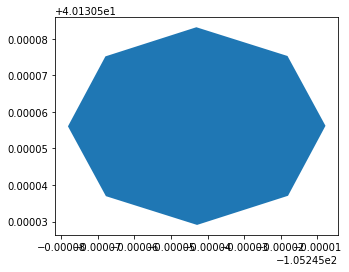

In [13]:
pt_df_hw.plot()

In [ ]:
pt_df_neon[0]

In [ ]:
# buffer them in the correct coordinate systems
temp_hw = pt_df.to_crs(epsg=32613).buffer(buffer_dist, resolution=res).to_crs(epsg=4326)
temp_neon = pt_df.to_crs(epsg=32613).buffer(buffer_dist)

In [ ]:
pt_df['geometry'][0]

In [ ]:
temp_hw[0]

In [ ]:
temp_neon[0]